# SRIM Calculations for stopping power and energy losses

The calculations are based on SRIM stopping power tables.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from srim import SR, Ion, Layer, Target

# directory where SRIM-2013 is located
srim_executable_directory = '/home/yulia/.wine/drive_c/Program Files (x86)/SRIM_2013_install'

/home/yulia/anaconda3/envs/deadlayer/lib/python3.6/site-packages/srim/core/elementdb.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(dbpath, "r"))


## Extrapolations to transuranium elements

It is a sea of unknown to find a good method to extrapolate stopping powers for transuranium elements.

Some relevant sources:

* General comparison of different models on the marker: [CriticalReviewStoppingPowers](CriticalReviewStoppingPowers.pdf)
* Example of use of extrapolation model in superheavy element experiment: [Wittwer2010](Wittwer2010.pdf)
* Calculation of effective charge: [P. Sigmund, 1997](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.56.3781)
* Other ways to calculate the effective charge: [Hubert](nucl-data-tables-stopping.pdf) & [Northcliffe](nucl-data-tables-stopping_low.pdf)

The very basics can be explained as with the example of derivating stopping powers for nobelium. By the use of the scaling relationship of the effective charge $q_{eff}$:
\begin{equation}
S_{No} = \frac{q_{eff, No}^2}{q_{eff, U}^2} S_U
\end{equation}
Where $ S_U $  and $S_{No} $ is the stopping power of uranium and nobelium respectively. As given in [P. Sigmund, 1997](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.56.3781) the effective charge is calculated as, 
\begin{align}
& q_{eff} = \lambda Z e \\
& \lambda = \sqrt{1-e^{-v_I/v_{TF}}}, \ v_{TF} = Z^{2/3}v_{0} = Z^{2/3} \alpha_{FS} c
\end{align}
where $ Z $ is the proton number, $ e $ the electronic charge, $ \alpha_{FS} $ the finestructure constant, $v_I$ is the ion velocity, and $ c $ the speed of light.  

Other models quantifies the effective charge differently, otherwise the scaling factor relationship can still be utilised.

#### Attenuation factor
According to the [review on the stopping power models](CriticalReviewStoppingPowers.pdf), and [Wittwer2010](Wittwer2010.pdf), SRIM overestimates the stopping power in general for low energy and heavy ions. Therefore it seems natural to further include an attenuation factor for the extrapolated stopping powers.

#### Target materials
Concerning target materials of transuranium elements, it should be sufficient with a linear scaling factor of the $Z$ of the reference element to the transuranic element of desire, see [Bethe-Bloch](https://en.wikipedia.org/wiki/Bethe_formula). I.e.

\begin{equation}
S_{No} = \frac{Z_{No}}{Z_U} S_U
\end{equation}

And here goes the implementation of the epSTF as introduced above.

In [4]:
e_charge = 1.6021766e-19
alpha_FS = 1./137
c_vac = 299792458
#c_vac = c_vac/1.9605
u = 931.494
def GetepSTF(z_ion, z_ref, A, S_ref, E):
    v_TF_ion = z_ion**(2./3)*alpha_FS*c_vac
    v_TF_ref = z_ref**(2./3)*alpha_FS*c_vac
    v1 = np.sqrt(2*np.divide(E,A))
    l_ion = np.sqrt(1-np.exp(-np.divide(v1, v_TF_ion)))
    l_ref = np.sqrt(1-np.exp(-np.divide(v1, v_TF_ref)))
    q_eff_ion = l_ion*z_ion
    q_eff_ref = l_ref*z_ref
    factor = np.square(np.divide(q_eff_ion, q_eff_ref))
    S_ion = np.multiply(S_ref, factor)
    return S_ion, factor

## Test inputs - Ion and Stopping materials

In [5]:
# Construct beam
A, E_per_A_max = 48, 7e6 # nucleon number, eV 
energy_max = A*E_per_A_max
#print("Max energy=", energy_max)
test_ion = Ion('Ca', energy=energy_max, mass=A)

# Al
density = 2.70e3 #mg/cm3 (from wikipedia)
# Construct a layer of Al, arbitrary width (as it is not relevant for these calcs)
test_layer = Layer({
    'Al': {
        'stoich': 1
        #'E_d': 35.0, # Displacement Energy
        #'lattice': 0.0,
        #'surface': 3.0
    }
}, density=1e-3*density, width=10000.0)

In [6]:
test_layer.elements

{<Element symbol:Al name:Aluminium mass:26.98>: {'stoich': 1.0,
  'E_d': 25.0,
  'lattice': 0.0,
  'surface': 3.0}}

## Class for the stopping power information

In [7]:
class GenerateStoppingPower():
    
    def __init__(self, layer, ion, z_ion = -1, Z = -1, Z_ref = -1, e_low_lim=1.1e-3, **kwargs):
        #srim = SR(layer, ion, output_type=5, energy_min=1100) 
        #output_type = 5, means MeV / (mg/cm2)
        srim = SR(layer, ion, output_type=5, energy_min=1002.) 
        results = srim.run(srim_executable_directory)

        self.energy_raw = 1e-3*results.data[0] #to MeV
        self.dEdX_raw = (results.data[1]+results.data[2])*(layer.density*1e3)*1e-4 # sum of electric and nuclear stopping power and convert to MeV per µm
        self.range_raw = results.data[3]
        #results.units
        
        if z_ion != -1:
            print("Extrapolating stopping power for ion with z=", z_ion)
            self.dEdX_raw, factor = GetepSTF(z_ion, ion.atomic_number, ion.mass, self.dEdX_raw, self.energy_raw)
            print("Mean scaling factor:", np.mean(factor))
            
        if Z != -1:
            print("Extrapolating stopping power for material with Z=", Z)
            factor = (float(Z)/Z_ref)
            self.dEdX_raw = factor*self.dEdX_raw
            print("Scaling factor:", factor)

        #interpolation of stopping power and range
        self.f_dEdX = interpolate.interp1d(self.energy_raw, self.dEdX_raw, kind='quadratic')
        self.energy_interp = np.arange(np.min(self.energy_raw), np.max(self.energy_raw), 10)
        self.f_range = interpolate.interp1d(self.energy_raw, self.range_raw, kind='quadratic')

        
        E_beam_0 = max(self.energy_raw) # MeV
        step_size = 0.1 #µm
        self.e_low_lim = e_low_lim # MeV

        e_loss = list()
        x_loss = list()

        e, x = [], []
        x_now = 0
        E_beam = E_beam_0
        e.append(E_beam)
        x.append(x_now)
        while E_beam > self.e_low_lim:
            #print("E_beam =",E_beam)
            x_now += step_size
            E_beam -= self.f_dEdX(E_beam)*step_size
            e.append(E_beam)
            x.append(x_now)
        self.x_loss = np.asarray(x)
        self.e_loss = np.asarray(e)
        self.f_eofx = (interpolate.interp1d(self.x_loss, self.e_loss, kind='quadratic'))
        self.f_xofe = (interpolate.interp1d(self.e_loss, self.x_loss, kind='quadratic'))  
        
        print("SRIM stopping power successfully calculated")
        print("\tCalculate energy loss as a function of traversed target material with function \'GetElossAfterX(E_init, x)'")
        print("\tCalculate traversed target material as a function of energy loss \'GetXAfterEloss(E_init, E_after)'")
        print("\tCalculate range in material as a function of energy \'GetRange(E_init)'")
        print("\tUnits: MeV, µm")

    def GetElossAfterX(self, E_init, x):
        #print("E_init=", E_init)
        x_start = self.f_xofe(E_init)
        #print("x_start=", x_start, "x_end=", x_start+x)
        x_end = x_start+x
        if isinstance(x_end, np.ndarray):
            #print("Yes, ndarray")
            ret = np.zeros(x_end.shape[0])
            inds = x_end > self.f_eofx.x[-1]
            if isinstance(E_init, np.ndarray):
                ret[inds] = E_init[inds]
                inds = x_end < self.f_eofx.x[-1]
                ret[inds] = E_init[inds] - self.f_eofx(x_end[inds]) 
            else:
                ret[inds] = E_init
                inds = x_end < self.f_eofx.x[-1]
                ret[inds] = E_init - self.f_eofx(x_end[inds]) 
            return ret
        else:
            if x_end > self.f_eofx.x[-1]:
                return E_init
            else:
                return E_init - self.f_eofx(x_end) 
    
    def GetXAfterEloss(self, E_init, E_after):
        x_start = self.f_xofe(E_init)
        return self.f_xofe(E_after) - x_start
    
    def GetRange(self, E_init, from_sr=False):
        if from_sr:
            return self.GetXAfterEloss(E_init, self.e_low_lim)
        else:
            return self.f_range(E_init)

In [13]:
GSP = GenerateStoppingPower(layer=test_layer, ion=test_ion)

SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm


In [9]:
GSP.f_xofe.x

array([-5.95993278e-02,  3.84934405e-02,  1.42653062e-01,  2.52030022e-01,
        3.63567830e-01,  4.77422143e-01,  5.94535500e-01,  7.15976368e-01,
        8.42760990e-01,  9.75779587e-01,  1.11583733e+00,  1.26363573e+00,
        1.41978404e+00,  1.58476385e+00,  1.75900616e+00,  1.94283271e+00,
        2.13647228e+00,  2.34008262e+00,  2.55372880e+00,  2.77742476e+00,
        3.01109444e+00,  3.25464494e+00,  3.50789418e+00,  3.77066037e+00,
        4.04271998e+00,  4.32384768e+00,  4.61373008e+00,  4.91203682e+00,
        5.21870411e+00,  5.53349506e+00,  5.85587358e+00,  6.18567077e+00,
        6.52272560e+00,  6.86665269e+00,  7.21721542e+00,  7.57421202e+00,
        7.93742989e+00,  8.30664100e+00,  8.68161669e+00,  9.06223572e+00,
        9.44838845e+00,  9.83990955e+00,  1.02365455e+01,  1.06380380e+01,
        1.10442623e+01,  1.14551307e+01,  1.18705301e+01,  1.22903114e+01,
        1.27143270e+01,  1.31424771e+01,  1.35746660e+01,  1.40107872e+01,
        1.44507261e+01,  

### Visualising test

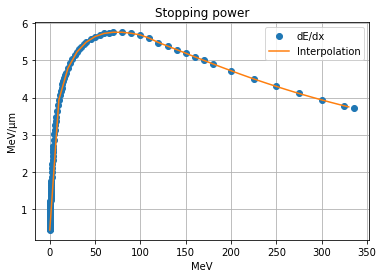

In [10]:
plt.plot(GSP.energy_raw, GSP.dEdX_raw, marker='o', label='dE/dx', linestyle='')
plt.plot(GSP.energy_interp, GSP.f_dEdX(GSP.energy_interp), label='Interpolation')
#plt.plot(energy, results.data[2], label='Sn')
plt.legend()

plt.xlabel('MeV')
plt.ylabel('MeV/µm')
plt.title("Stopping power")
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-2, 1e2)
#plt.ylim(1, None)
plt.grid()
#plt.show()

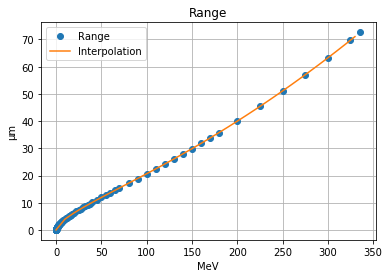

In [11]:
plt.plot(GSP.energy_raw, GSP.range_raw, marker='o', label='Range', linestyle='')
plt.plot(GSP.energy_interp, GSP.GetRange(GSP.energy_interp), label='Interpolation')
#plt.plot(energy, results.data[2], label='Sn')
plt.legend()

plt.xlabel('MeV')
plt.ylabel('µm')
plt.title("Range")
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-2, 1e2)
#plt.ylim(1, None)
plt.grid()
#plt.show()

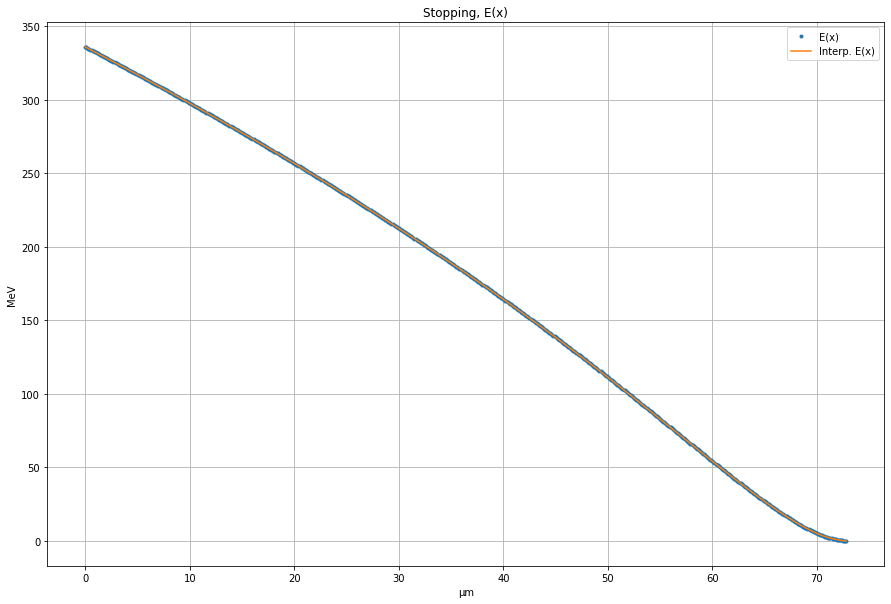

In [12]:
plt.figure(figsize=(15,10))
plt.plot(GSP.x_loss, GSP.e_loss, marker='.', label='E(x)', linestyle='')
plt.plot(GSP.x_loss, GSP.f_eofx(GSP.x_loss), marker='', label='Interp. E(x)', linestyle='-')
plt.legend()

plt.xlabel('µm')
plt.ylabel('MeV')
plt.title('Stopping, E(x)')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-2, 1e2)
#plt.ylim(1, None)
plt.grid()
#plt.show()

In [ ]:
print("Successfully imported \'GenerateStoppingPower\'\n\tClass to Generate SRIM Stopping Power and calculate energy loss and traversed material.")